This script walks the user through calibration of the FiLM-Scope, using an example calibration dataset (see README for download information). 

In [1]:
# import
from filmscope.calibration import (SystemVertexParser, CalibrationInfoManager, SystemCalibrator,
                                   Filmscope_System)
from filmscope.util import load_graph_images, load_dictionary, generate_A_matrix
from filmscope.config import path_to_data
from matplotlib import pyplot as plt 
import matplotlib
import numpy as np
import os

In [2]:
# Delete this cell
path_to_data = 'D:/20241226_fluoro_chicken'

Step 1: Parse Vertices

This will load the calibration dataset with images of the graph target, and extract the location of the graph vertices in all images.

In [3]:
# set image_folder to the path of the folder with the graph calibration images
# and calibration_filename to the filename where the calibration information will be stored

image_folder = path_to_data#path_to_data + "/20241118_test_color_calibration" #"/calibration_data"
calibration_filename = path_to_data + '/calibration_information' #"calibration_information_delete"#image_folder + "/calibration_information"

info_manager = CalibrationInfoManager(calibration_filename)

In [4]:
os.path.exists(path_to_data)

True

In [5]:
#known information
# spacing between vertices in the calibration graph
#info_manager.vertex_spacing_m = 1e-2
info_manager.vertex_spacing = 2e-3 #0.004357142857142857
# pixel size for the FiLMScope
info_manager.pixel_size = 1.1e-6

info_manager.save_all_info()

In [6]:
# specify which image numbers are used
# if it's not all of them 
info_manager.image_numbers = None 

info_manager.image_numbers = [13, 
                              14, 15, 16, 
                              19, 20, 21, 22,
                              25, 26, 27, 28,
                              31,
                              32, 33, 34]

In [7]:
# specify file naming convention for the graph images 
# name_dict just needs to contain a unique portion of the string 
# for the graph images to be used here
num_graphs = 6
name_dict = {}
for i in range(num_graphs):
    name_dict[i] = f"graph_0{i}"  #### switch back to graph_0{i} !!!!!!!!!!!!!!!!!! TODO

info_manager.plane_names = name_dict

In [8]:
# batch size sets how many images will be loaded at once 
batch_size = 16
all_planes = np.arange(num_graphs)
# 48 images are used in this dataset
if info_manager.image_numbers is None:
    all_cam_nums = np.arange(48)
else:
    all_cam_nums = info_manager.image_numbers

loading images: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


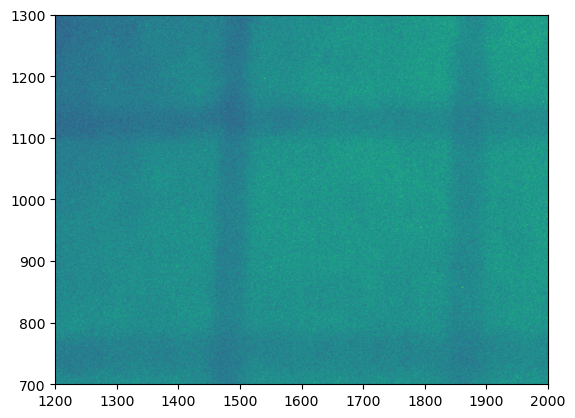

In [9]:
# load and display an image to manually set the expected spacing between graph vertices
# this graph target has both "major" and "minor" lines, and we only extract vertices
# of the major lines
img = load_graph_images(
    folder=image_folder, image_numbers=[all_cam_nums[0]], plane_numbers=[all_planes[0]],
    calibration_filename=calibration_filename,ensure_grayscale=True,
)[all_planes[0]][all_cam_nums[0]]
plt.figure()
plt.imshow(img)
plt.ylim(700, 1300)
plt.xlim(1200, 2000)
plt.show()

In [10]:
expected_spacing = int(2410 - 1920)
print(expected_spacing)

expected_spacing = 400

490


In [11]:
# define function to select the plane and camera numbers
# for the next set of images to be processed
# IMPORTANT NOTE: right now the vertex parser has to have
# the same number of cameras in all planes,
# so when batching is used, we only use images from one plane at a time
def get_camera_plane_numbers(batch_size, all_planes, all_cameras):
    info_manager = CalibrationInfoManager(calibration_filename)
    vertices = info_manager.all_vertices

    plane_numbers = []
    camera_numbers = []
    num_images = 0
    chosen_plane = False
    for plane in all_planes:
        if plane not in vertices:
            chosen_plane = True
            camera_numbers = all_cameras[:batch_size]
            plane_numbers.append(plane)
            break
        else:
            cam_vertices = vertices[plane]
            for cam in all_cameras:
                if cam in cam_vertices:
                    continue
                else:
                    chosen_plane = True
                camera_numbers.append(cam)
                num_images = num_images + 1
                if num_images >= batch_size:
                    break
            if chosen_plane:
                plane_numbers.append(plane)
                break
    if not chosen_plane:
        return [-1], [-1]
    return np.asarray(plane_numbers), np.asarray(camera_numbers)

In [12]:
# go through one set of images to ensure parsing settings are working

In [13]:
plane_numbers, camera_numbers = get_camera_plane_numbers(
    batch_size, all_planes, all_cam_nums
)
if plane_numbers[0] == -1:
    print("Done! All vertices found!")
else:
    print("plane:", plane_numbers, "camera numbers:", camera_numbers)


plane_numbers = [5]
camera_numbers = [13, 14, 15, 16, 19, 20, 21, 22, 25,
                  26, 27, 28, 31, 32, 33, 34]
all_images = load_graph_images(
    folder=image_folder,
    image_numbers=camera_numbers,
    plane_numbers=plane_numbers,
    calibration_filename=calibration_filename
)

parser = SystemVertexParser(
    calibration_filename,
    expected_vertex_spacing=expected_spacing,
    all_images=all_images,
    camera_numbers=camera_numbers,
    plane_numbers=plane_numbers,
    display_downsample=4,
    lsf_range=175
)

Done! All vertices found!


loading images: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


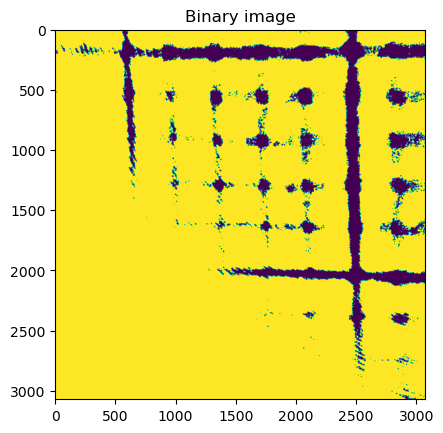

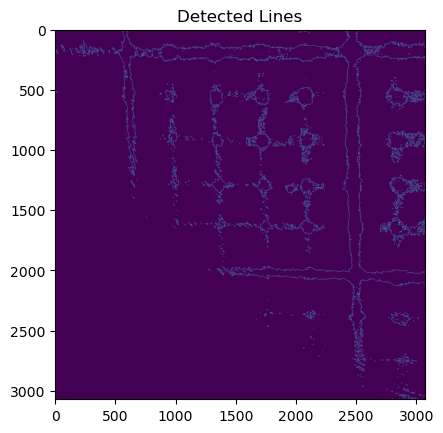

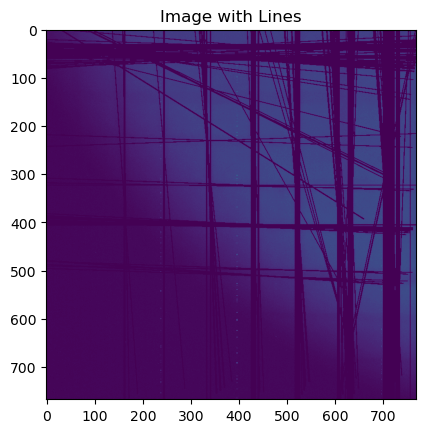

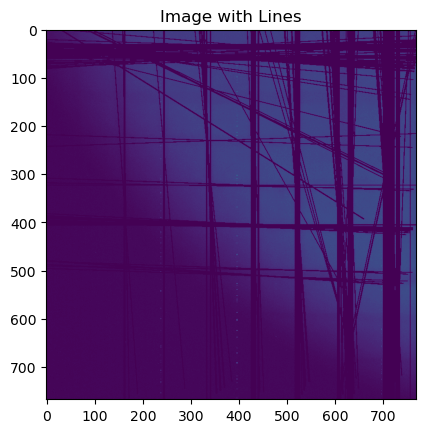

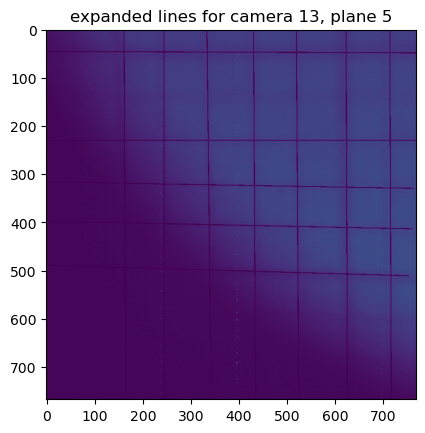

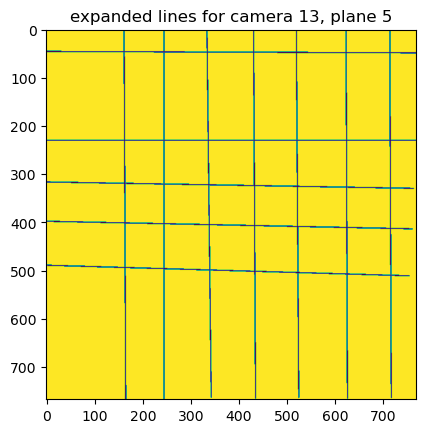

In [15]:
# use this cell to adjust threshold values
# see the README in the calibration folder
# for more info on settings these values  
threshold_values = {
    # used in "cv2.adaptiveThreshold" to convert graph images to binary images
    # should be an add number that approximately matches the expected spacing
    "adaptive_threshold_range": 2 * int(expected_spacing / 2) + 1,
    # used in cv2.medianBlur to filter the binary image
    # larger numbers will blur out smaller features in the image other than the
    # graph lines we are trying to identify
    "blur_range": 11,
    # "edge_thresh" and "edge_aperture" are used in cv2.Canny
    # to identify edges in the images. 
    # consult cv2 documentation for use
    "edge_thresh1": 50,
    "edge_thresh2": 200,
    "edge_aperture": 5,
    # line_thresh_per_pixel * #pixel used in cv2.HoughLines to 
    # identify lines from edges
    "line_thresh_per_pixel": 0.07,
}

# uncomment this line to use the default threshold values
# threshold_values = None

# select a camera # and plane # from the list of loaded images
# to manually adjust threshold values for that image 
cam = camera_numbers[0]
plane = plane_numbers[0]
parser.find_lines(
    cam, plane, show=True, show_process=True, threshold_values=threshold_values
)
plt.show()

In [17]:
# when the settings seem reasonable, find the remaining lines
parser.find_all_remaining_lines(show=False, threshold_values=threshold_values)

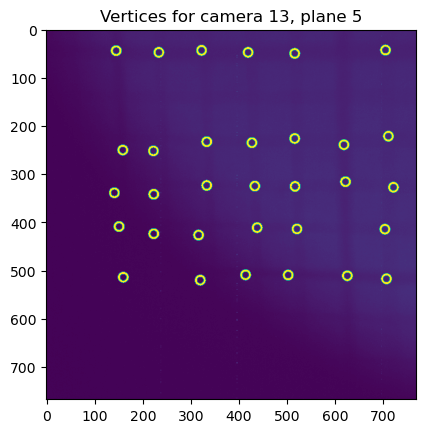

In [16]:
for cam in camera_numbers:
    parser.find_vertices(cam, 5, show=True)
    break

In [18]:
# click this cell multiple times until all vertices have been found
# it will show the results for "display_size" results at a time
# to confirm the results are adequate

# if not (a large number of vertices are not identified or many extraneous vertices are)
# go back two cells to fix the threshold values
display_size = 16
parser.find_all_remaining_vertices(show=True, max_display=display_size)

In [17]:
#upsample = parser.display_downsample
#v = parser.debug_missing_point(camera_number=15, plane_number=0, approx_location=(300*upsample, 400*upsample))

In [19]:
parser.save_all_parameters()
plt.close()

In [ ]:
# once settings are adequate, this cell will do the remaining processing
# to find the vertices for all images
while True:
    plane_numbers, camera_numbers = get_camera_plane_numbers(
        batch_size, all_planes, all_cam_nums
    )
    if plane_numbers[0] == -1:
        print("Done! All vertices found!")
        break
    else:
        print("planes:",plane_numbers, "image #:", camera_numbers)

    all_images = load_graph_images(
        folder=image_folder,
        image_numbers=camera_numbers,
        plane_numbers=plane_numbers,
        calibration_filename=calibration_filename
    )

    parser = SystemVertexParser(
        calibration_filename=calibration_filename,
        expected_vertex_spacing=expected_spacing,
        all_images=all_images,
        camera_numbers=camera_numbers,
        plane_numbers=plane_numbers,
        display_downsample=4,
    )

    parser.find_all_remaining_lines(show=False, max_display=100)
    parser.find_all_remaining_vertices(show=False, max_display=100)
    parser.save_all_parameters()

In [ ]:
%debug

Step 2: Remove extraneous vertices

While this step can be improved in future versions, right now extraneous vertices must be manually removed, or they will impact the calibration results. This can be done by running ``remove_vertices.py`` (first open the file and adjust necessary settings). For demo purposes, this step can be skipped by running the cell below to use previously identified vertices for later steps in this notebook

In [ ]:
%debug

In [ ]:
# run this cell to proceed with previously identified vertices
demo_calibration_filename = image_folder + '/calibration_information_example'
info_manager = CalibrationInfoManager(calibration_filename)
info_manager.all_vertices = load_dictionary(demo_calibration_filename)["all_vertices"]
info_manager.save_all_info()

Step 3: identify approximate alignment points between images

This step can likely be automated in future versions of the code, but right now the user must manually select approximate alignment points between the images. This can be done by finding a feature visible in all 48 images, then running ``select_alignment_points.py`` to click on that point in all the images. This step can be skipped in the demo by running the cell below to use previously identified alignment points. 

In [ ]:
# run this cell to proceed with previously identified alignment points
demo_calibration_filename = image_folder + '/calibration_information_example'
info_manager = CalibrationInfoManager(calibration_filename)
info_manager.approx_alignment_points = load_dictionary(demo_calibration_filename)["approx_alignment_points"]
info_manager.save_all_info()

# confirm that was done correctly 
assert len(info_manager.approx_alignment_points) > 0

Step 4: Fit calibration coefficients 

In this portion, the identified graph vertices are used to perform inter- and intr-camera calibration

In [ ]:
# this can be uncommented to display interactive plots
#%matplotlib notebook

In [20]:
# this can be set to any camera, but we recommend using one of the 4 center cameras
# (20, 21, 26 or 27)
reference_camera = 21

In [21]:
# select reference plane based on how many vertices were identified in each plane
# the first number gives the total number of vertices identified in a given plane 
# between all 48 images
# and the second number is the number of identified vertices in the image with the 
# least identified vertices.
# both of these numbers should be reasonably large in the chosen reference plane
vertices = load_dictionary(calibration_filename)['all_vertices']

for plane_num, values in vertices.items():
    plane_points = 0
    min_points = np.inf
    for cam, points in values.items():
        plane_points = plane_points + len(points) 
        min_points = min(min_points, len(points))
    print(plane_num, "total points:", plane_points, ", mininum points in an image:", min_points)

0 total points: 841 , mininum points in an image: 27
1 total points: 783 , mininum points in an image: 23
2 total points: 766 , mininum points in an image: 28
3 total points: 744 , mininum points in an image: 21
4 total points: 721 , mininum points in an image: 24
5 total points: 810 , mininum points in an image: 16


In [22]:
reference_plane = 1

In [23]:
plane_separation_mm = 1 
calibrator = SystemCalibrator(
    calibration_filename=calibration_filename,
    reference_plane=reference_plane,
    reference_camera=reference_camera,
    plane_separation_mm = plane_separation_mm,
    ref_plane_image_folder = image_folder,#None,
    useable_plane_numbers = np.arange(5) # if None, this will use all planes
)

loading images: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


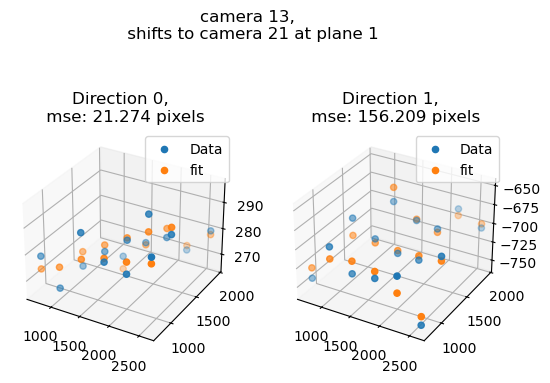

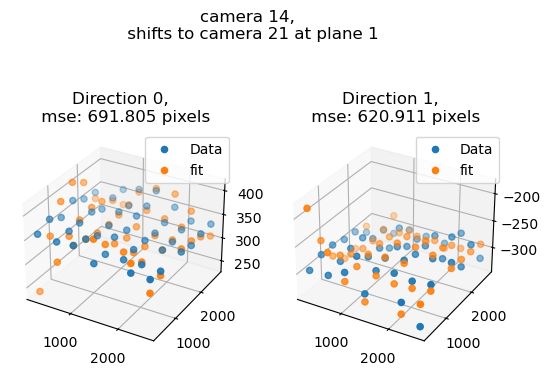

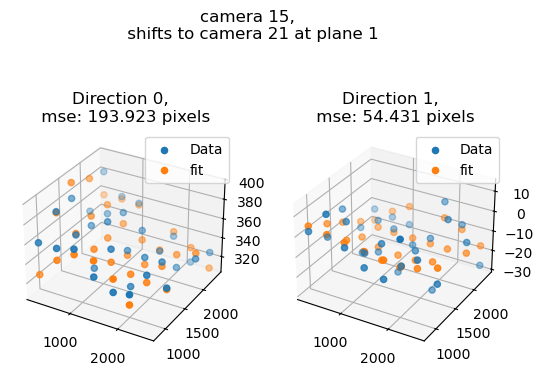

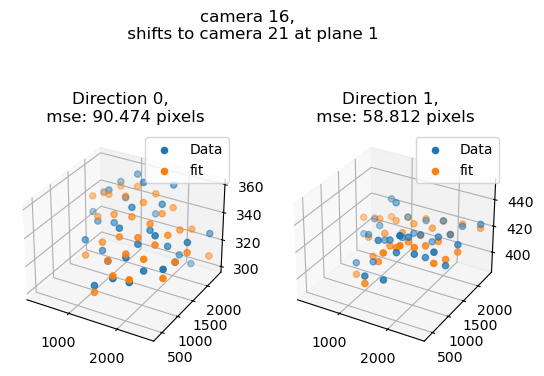

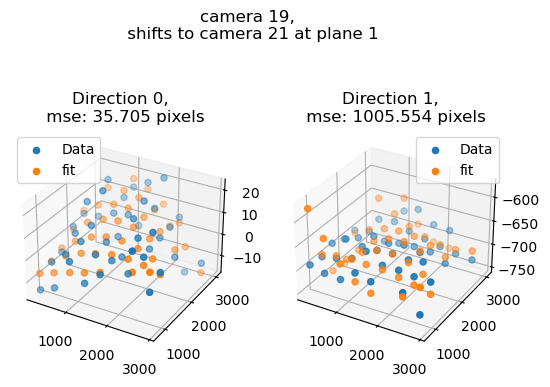

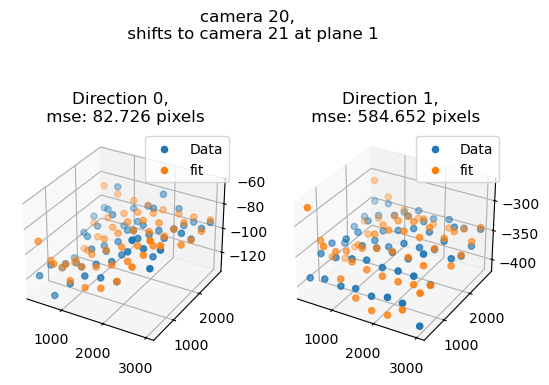

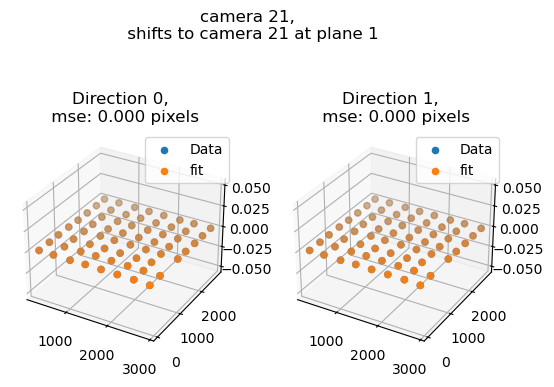

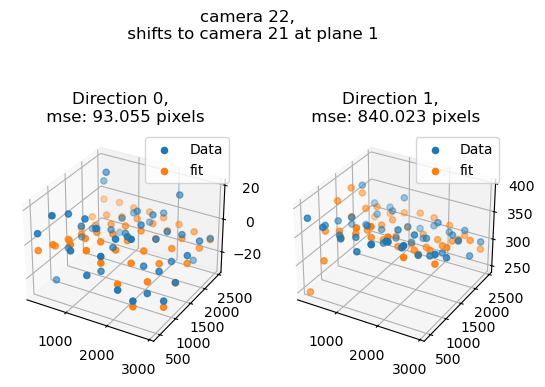

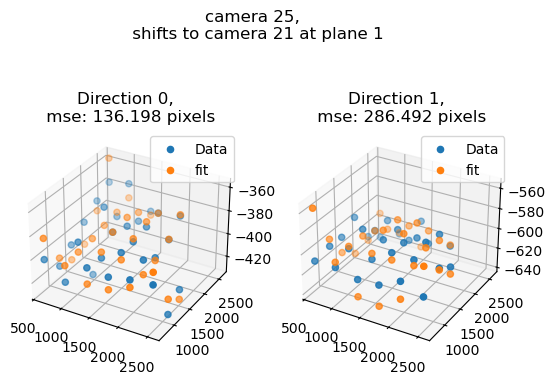

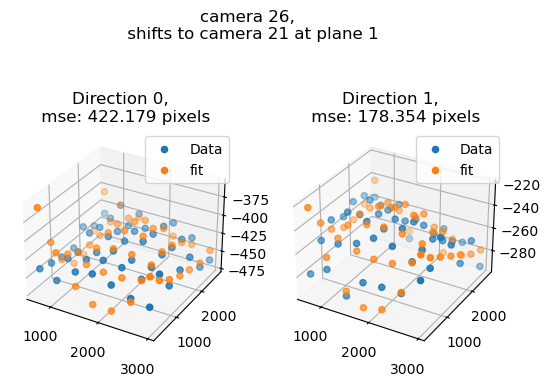

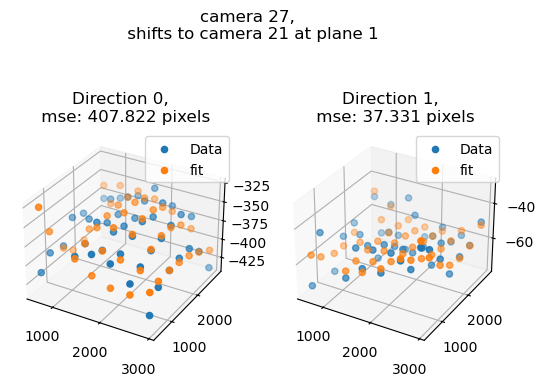

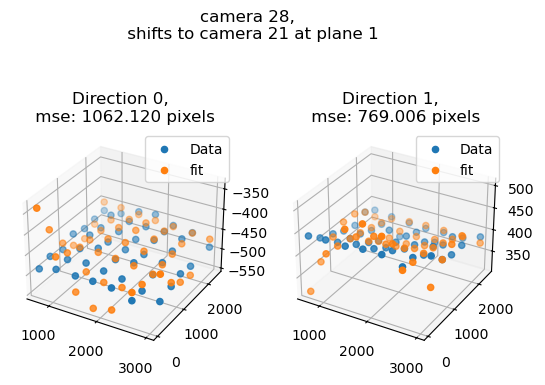

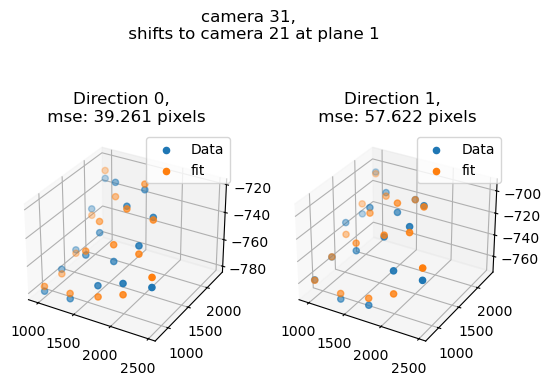

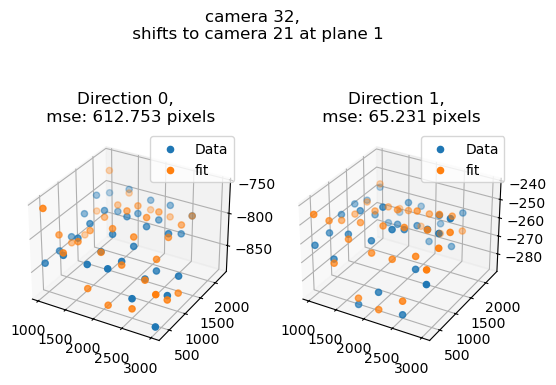

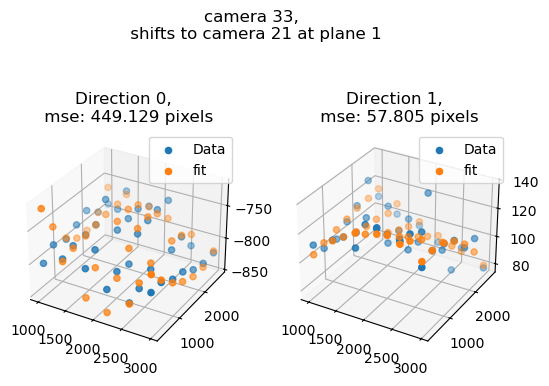

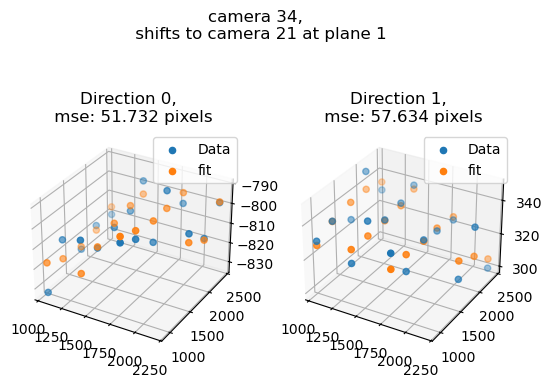

In [24]:
calibrator.run_inter_camera_calibration(show=True, order=2)

c:\Users\clare\anaconda3\envs\torch_compatible\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\clare\anaconda3\envs\torch_compatible\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


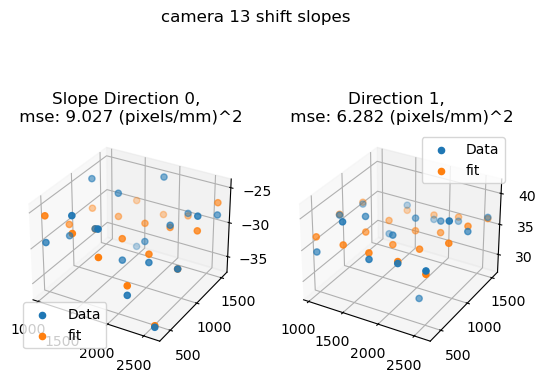

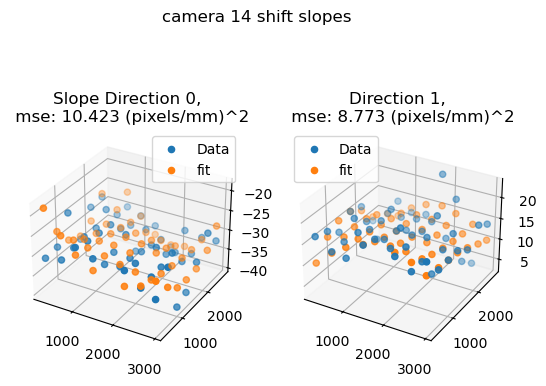

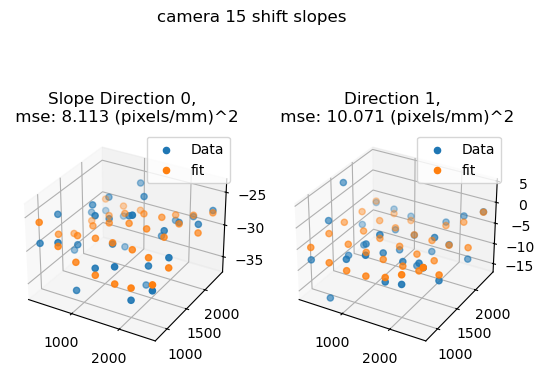

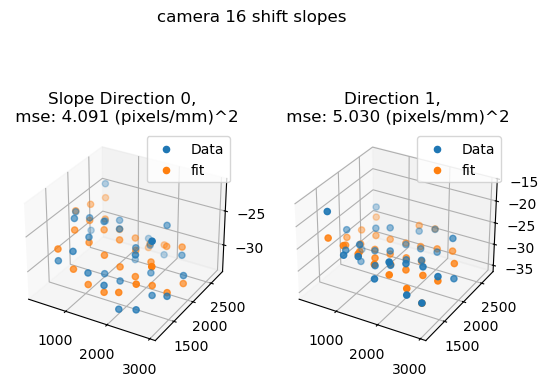

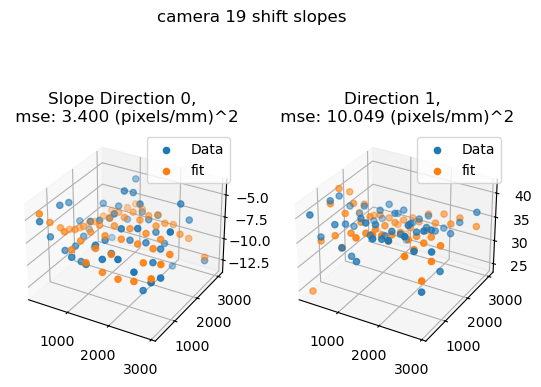

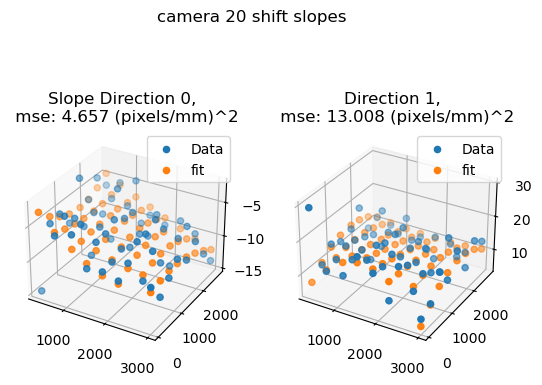

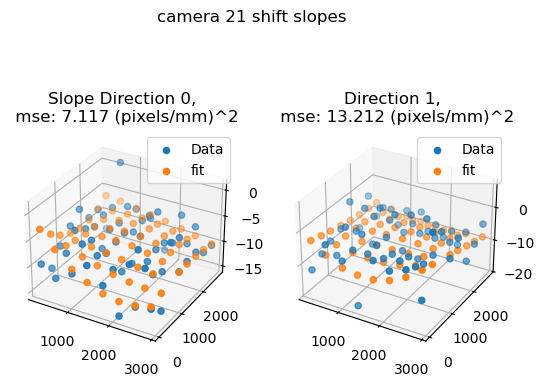

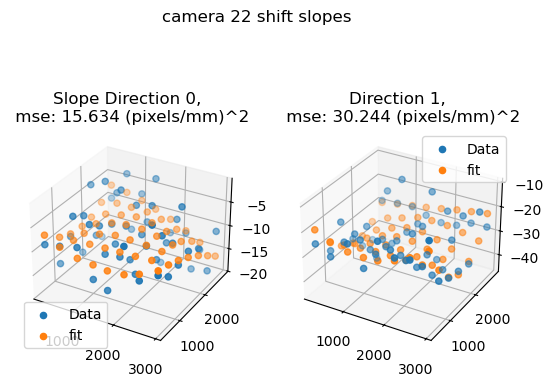

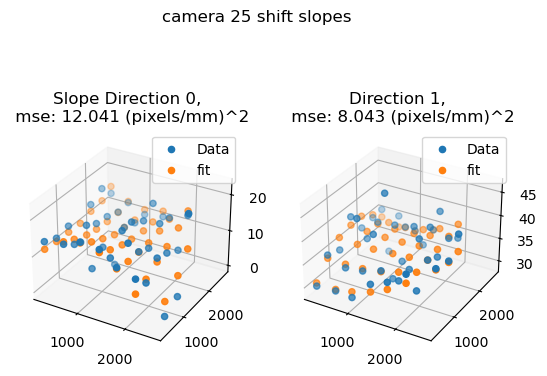

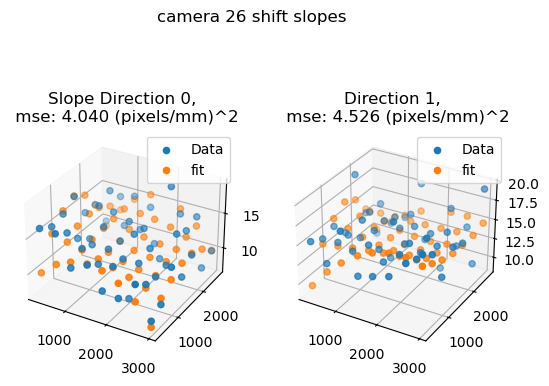

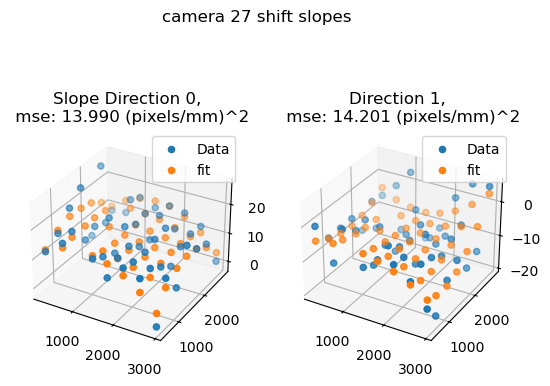

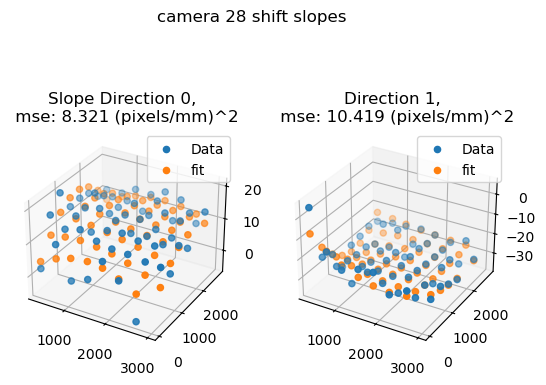

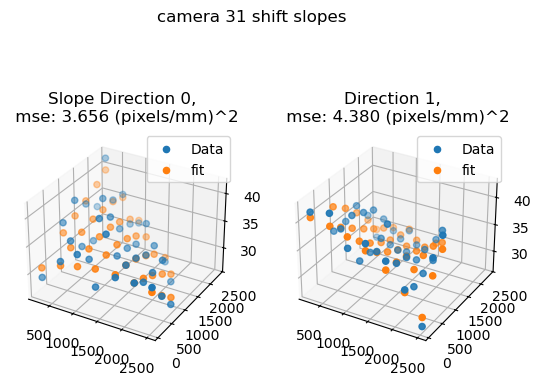

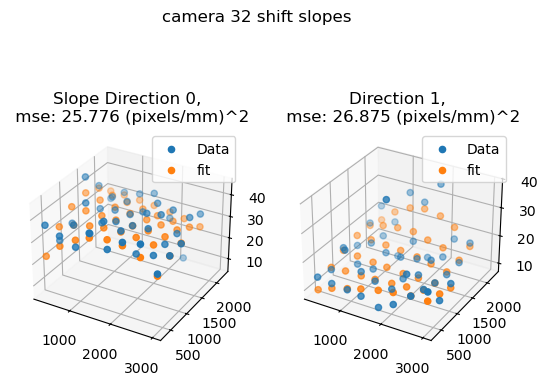

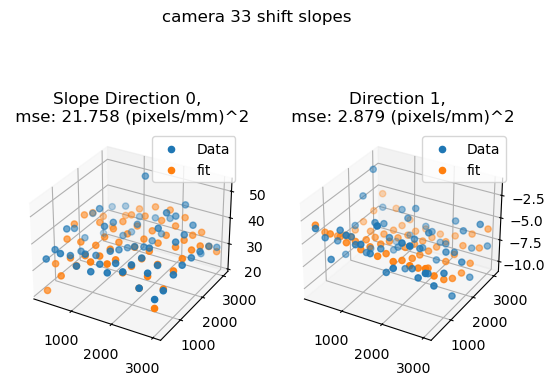

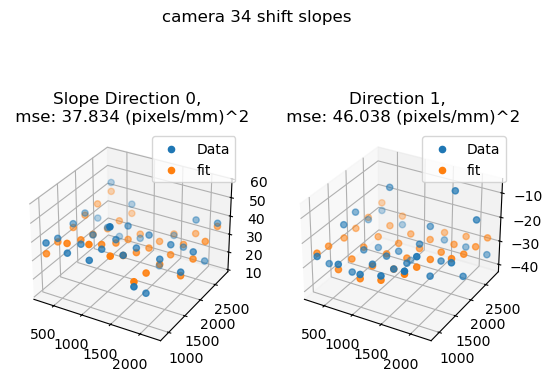

In [25]:
calibrator.run_slope_calibration(show=True, order=2)

Step 5: check if results look reasonable

In [26]:
system = Filmscope_System(calibration_filename)
plane_separation_mm = system.calib_manager.plane_separation_mm
calibrator = SystemCalibrator(calibration_filename)
calibrator.get_all_camera_vertices_matrices()
all_camera_vertices_matrices = calibrator.all_camera_vertices_matrices

image_shape = system.calib_manager.image_shape

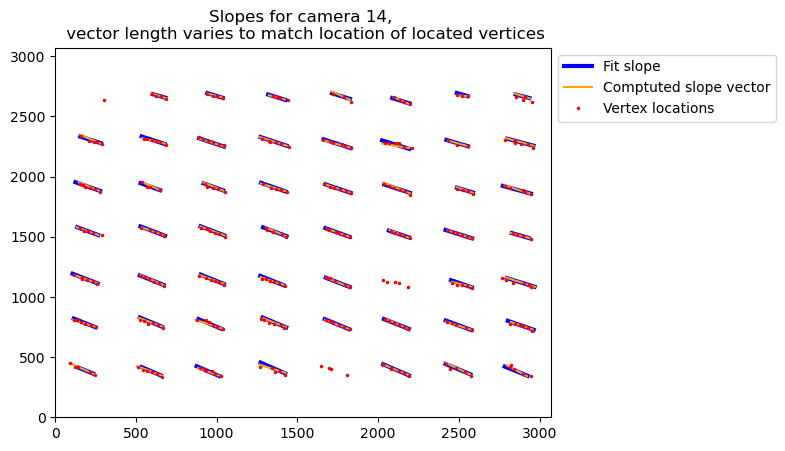

In [27]:
def make_comparison_plot(camera_number, vector_length_mm=None):
    slope0, slope1 = calibrator.get_slopes_from_vertices_matrices(camera_number)
    vertices_matrices = all_camera_vertices_matrices[camera_number]

    plt.figure()
    matrix_shape = vertices_matrices.shape[1:3]
    first = True
    for i, j in np.ndindex(matrix_shape):
        if first:
            label1 = "Comptuted slope vector"
            label2 = "Fit slope"
            label3 = "Vertex locations"
        else:
            label1 = None
            label2 = None
            label3 = None

        X = vertices_matrices[:, i, j, 0]
        Y = vertices_matrices[:, i, j, 1]

        if not np.isnan(slope0[i, j]):
            if vector_length_mm is None:
                start_plane_mm = (
                    np.where(~np.isnan(X))[0][0] - system.reference_plane
                ) * plane_separation_mm
                end_plane_mm = (
                    np.where(~np.isnan(X))[0][-1] - system.reference_plane
                ) * plane_separation_mm
            else:
                start_plane_mm = -vector_length_mm / 2
                end_plane_mm = vector_length_mm / 2

            x = vertices_matrices[system.reference_plane, i, j, 0]
            y = vertices_matrices[system.reference_plane, i, j, 1]

            # plot the slope vector that was fit to that point
            coeff0, coeff1 = system._get_slope_coeffs(camera_number)
            slope_matrix = generate_A_matrix(system.shift_order, [x], [y])
            v1 = np.matmul(slope_matrix, coeff0)[0]
            v0 = np.matmul(slope_matrix, coeff1)[0]
            x_start = x + v0 * start_plane_mm
            x_end = x + v0 * end_plane_mm
            y_start = y + v1 * start_plane_mm
            y_end = y + v1 * end_plane_mm
            plt.plot(
                [x_start, x, x_end],
                [y_start, y, y_end],
                "-",
                linewidth=3,
                color="blue",
                label=label2,
            )

            s0 = slope0[i, j]
            s1 = slope1[i, j]
            x_start = x + s0 * start_plane_mm / plane_separation_mm
            x_end = x + s0 * end_plane_mm / plane_separation_mm
            y_start = y + s1 * start_plane_mm / plane_separation_mm
            y_end = y + s1 * end_plane_mm / plane_separation_mm

            # plot the originally calculated slope vector
            plt.plot(
                [x_start, x, x_end],
                [y_start, y, y_end],
                "-",
                markersize=2,
                color="orange",
                label=label1,
            )

        if False in np.isnan(X):
            plt.plot(X, Y, ".", markersize=3, color="red", label=label3)
            first = False

    plt.legend(bbox_to_anchor=(1, 1))
    if vector_length_mm is not None:
        title = f"Slopes for camera {camera_number}, \n shown for {vector_length_mm} mm axial shift"
    else:
        title = f"Slopes for camera {camera_number}, \n vector length varies to match location of located vertices"
    plt.title(title)

    plt.ylim([0, image_shape[0]])
    plt.xlim([0, image_shape[1]])


make_comparison_plot(14, vector_length_mm=None)

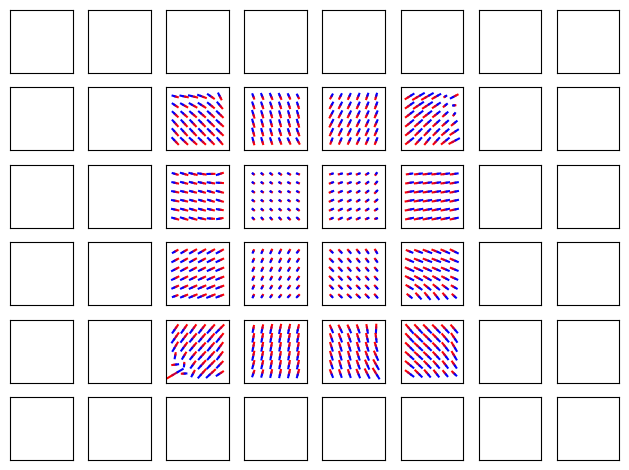

In [28]:
# Next plot: choose points in the image and plot lines that show how those points shift ?
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
def vector_plot(
    camera_number, vector_length_mm=10, ax=None, add_colorbar=True, add_title=True, s=50
):
    coeffs0, coeffs1 = system._get_slope_coeffs(camera_number)

    # pick locations in the image
    x_locs = np.linspace(0, image_shape[1], 8)[1:-1]
    y_locs = np.linspace(0, image_shape[0], 8)[1:-1]

    start_plane_mm = -vector_length_mm / 2
    end_plane_mm = vector_length_mm / 2

    # coloring array
    T = np.linspace(0, 1, s) ** 2

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    for x in x_locs:
        for y in y_locs:
            slope_matrix = generate_A_matrix(system.shift_order, [x], [y])
            v1 = np.matmul(slope_matrix, coeffs0)[0]
            v0 = np.matmul(slope_matrix, coeffs1)[0]

            x_start = x + v0 * start_plane_mm
            x_end = x + v0 * end_plane_mm
            y_start = y + v1 * start_plane_mm
            y_end = y + v1 * end_plane_mm

            # segment length
            s_x = (x_end - x_start) / s
            s_y = (y_end - y_start) / s

            colors = []
            for i in range(0, s):
                color = (1 - T[i], 0, T[i])
                colors.append(color)
                ax.plot(
                    [x_start + s_x * i, x_start + (s_x * (i + 1))],
                    [y_start + s_y * i, y_start + (s_y * (i + 1))],
                    color=color,
                )

    plt.xlim([0, image_shape[0]])
    plt.ylim([0, image_shape[1]])
    plt.gca().invert_yaxis()

    if add_colorbar:
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        cmap = matplotlib.colors.ListedColormap(np.flip(np.asarray(colors), axis=1))
        norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
        matplotlib.colorbar.ColorbarBase(
            ax2, cmap=cmap, norm=norm, spacing="proportional", format="%1i"
        )

    if add_title:
        ax.set_title(f"Axial Shifts for Camera {camera_number}")
        ax.set_xlabel("Pixel Location (X)")
        ax.set_ylabel("Pixel Location (Y)")
    return ax

# showing all the vertices in each camera
fig, axes = plt.subplots(6, 8)
camera_numbers = np.arange(48)
for camera_number in camera_numbers:
    ax_num0 = 5 - (camera_number % 6)
    ax_num1 = int(camera_number / 6)

    axis = axes[ax_num0, ax_num1]
    if camera_number in system.calib_manager.image_numbers:
        vector_plot(
            camera_number=camera_number,
            vector_length_mm=10,
            ax=axis,
            add_colorbar=False,
            add_title=False,
            s=3,
        )

    axis.set_xlim([0, image_shape[1]])
    axis.set_ylim([0, image_shape[0]])

    axis.set_xticks([])
    axis.set_yticks([])
    axis.invert_yaxis()
    axis.set_aspect("equal")
plt.tight_layout()

In [ ]:
cmap = matplotlib.cm.turbo 
info_manager.image_numbers
# this is not ideal.... 
organized_nums = np.asarray([[13, 14, 15, 16],
                  [19, 20, 21, 22],
                  [25, 26, 27, 28],
                  [31, 32, 33, 34]]).T
organized_nums = np.flipud(organized_nums)

minx = np.inf 
miny = np.inf 
minnorm = np.inf 

maxx = -np.inf 
maxy = -np.inf 
maxnorm = -np.inf

# points we'll use... 
x_vals = np.linspace(300, 4000, 4) 
y_vals = np.linspace(300, 3000, 4)
for camera in info_manager.image_numbers:
    for xi, yi in np.ndindex((len(x_vals), len(y_vals))):
        x = x_vals[xi] 
        y = y_vals[yi]

        v0, v1 = system.get_shift_slopes(camera, [x], [y])

        minx = min(minx, v0) 
        miny = min(miny, v1) 
        minnorm = min(minnorm, np.linalg.norm([v0, v1]))

        maxx = max(maxx, v0) 
        maxy = max(maxy, v1) 
        maxnorm = max(maxnorm, np.linalg.norm([v0, v1]))


scale = 12
fig, axes = plt.subplots(4, 4) 
for i, j in np.ndindex(axes.shape):
    axis = axes[i, j] 
    camera = organized_nums[i, j] 
    for xi, yi in np.ndindex((len(x_vals), len(y_vals))):
        x = x_vals[xi] 
        y = y_vals[yi]

        v0, v1 = system.get_shift_slopes(camera, [x], [y])

        norm = np.linalg.norm([v0, v1]) 
        n2 = (norm - minnorm) / (maxnorm - minnorm)
        color = cmap(n2)

        axis.plot([y - v1 /2 * scale, y + v1 / 2 * scale], [x - scale * v0 / 2, x + scale * v0 / 2], color=color)
        axis.annotate('',
                xy=(y - v1 /2 * scale - 0.01 * v1, x - v0 / 2 * scale - 0.01 * v0),  # Arrow tip
                xytext=(y - v1 /2 * scale, x - v0 / 2 * scale),  # Arrow base
                arrowprops=dict(facecolor=color, arrowstyle='->', color=color), color=color)

    axis.set_ylim([0, image_shape[0]])
    axis.set_xlim([0, image_shape[1]])
    #axis.set_xticks([])
    #axis.set_yticks([])
    axis.invert_yaxis()
    axis.set_aspect('equal')
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_facecolor('black')
plt.tight_layout()

In [ ]:
cmap = matplotlib.cm.turbo

camera = 15
x_vals = np.arange(300, 4000)[::400]
y_vals = np.arange(300, 3000)[::400]

minx = np.inf 
miny = np.inf 
minnorm = np.inf 

maxx = -np.inf 
maxy = -np.inf 
maxnorm = -np.inf 

scale = 10
for x in x_vals:
    for y in y_vals:
        v0, v1 = system.get_shift_slopes(camera, [x], [y])

        minx = min(minx, v0) 
        miny = min(miny, v1) 
        minnorm = min(minnorm, np.linalg.norm([v0, v1]))

        maxx = max(maxx, v0) 
        maxy = max(maxy, v1) 
        maxnorm = max(maxnorm, np.linalg.norm([v0, v1]))
minnorm = minnorm #- 1
fig, axis = plt.subplots(1, 1)
for x in x_vals:
    for y in y_vals:

        v0, v1 = system.get_shift_slopes(camera, [x], [y])

        norm = np.linalg.norm([v0, v1]) 
        n2 = (norm - minnorm) / (maxnorm - minnorm)
        color = cmap(n2)
        
        axis.plot([y - v1 /2 * scale, y + v1 / 2 * scale], [x - scale * v0 / 2, x + scale * v0 / 2], color=color)

        axis.annotate('',
                xy=(y - v1 /2 * scale - 0.01 * v1, x - v0 / 2 * scale - 0.01 * v0),  # Arrow tip
                xytext=(y - v1 /2 * scale, x - v0 / 2 * scale),  # Arrow base
                arrowprops=dict(facecolor=color, arrowstyle='->', color=color), color=color)

axis.set_xlim([0, 3072])
axis.set_ylim([0, 4096])
#axis.set_xticks([])
#axis.set_yticks([])
axis.invert_yaxis()
axis.set_aspect('equal')

axis.set_facecolor('black')
axis.set_title(f"Camera {camera}")

mn = minnorm #+ 1
a = np.random.random((100, 100)) * (maxnorm - mn) + mn
plt.figure()
plt.imshow(a, cmap=cmap, clim=(minnorm, maxnorm))
plt.colorbar()
plt.title("min: {:.2f}, max: {:.2f}".format(mn, maxnorm))

In [ ]:
# and I'm going to make calibration plots for this round
organized_nums = np.asarray([[13, 14, 15, 16],
                  [19, 20, 21, 22],
                  [25, 26, 27, 28],
                  [31, 32, 33, 34]]).T
organized_nums = np.flipud(organized_nums)

minx = np.inf 
miny = np.inf 
minnorm = np.inf 

maxx = -np.inf 
maxy = -np.inf 
maxnorm = -np.inf 

cmap = plt.cm.turbo

for camera_number in info_manager.image_numbers:
    v0, v1 = system.get_shift_slopes(camera_number, [2000], [1500])

    minx = min(minx, v0) 
    miny = min(miny, v1) 
    minnorm = min(minnorm, np.linalg.norm([v0, v1]))

    maxx = max(maxx, v0) 
    maxy = max(maxy, v1) 
    maxnorm = max(maxnorm, np.linalg.norm([v0, v1]))

fig, axes = plt.subplots(4, 4) 
minnorm = minnorm #- 10
for i, j in np.ndindex(organized_nums.shape):
    axis = axes[i, j] 
    camera_number = organized_nums[i, j]

    v0, v1 = system.get_shift_slopes(camera_number, [2000], [1500])

    norm = np.linalg.norm([v0, v1]) 
    n2 = (norm - minnorm) / (maxnorm - minnorm)
    color = cmap(n2)

    axis.plot([-v1 / 2, v1 / 2], [-v0 / 2, v0 / 2], color=color)

    axis.annotate('',
            xy=(-v1 / 2 + -v1 * 0.008, -v0 / 2 + -v0 * 0.008),  # Arrow tip
            xytext=(-v1 / 2 , -v0 / 2),  # Arrow base
            arrowprops=dict(facecolor=color, arrowstyle='->', color=color), color=color)

    axis.set_xlim([minx, maxx])
    axis.set_ylim([miny, maxy])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.invert_yaxis()

    axis.set_facecolor('black')
    axis.set_aspect("equal")

mn = minnorm #+ 10 
a = np.random.random((100, 100)) * (maxnorm - mn) + mn
plt.figure()
plt.imshow(a, cmap=cmap, clim=(minnorm, maxnorm))
plt.colorbar()
plt.title("min: {:.2f}, max: {:.2f}".format(mn, maxnorm))
plt.xticks([])
plt.yticks([])